In [1]:
%matplotlib inline
import collections
import gym
import matplotlib.pyplot as plot
import numpy as np
import time
import torch as t

from IPython.display import clear_output

In [2]:
env = gym.make('CartPole-v1')
#env = env.unwrapped

/home/user/.local/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


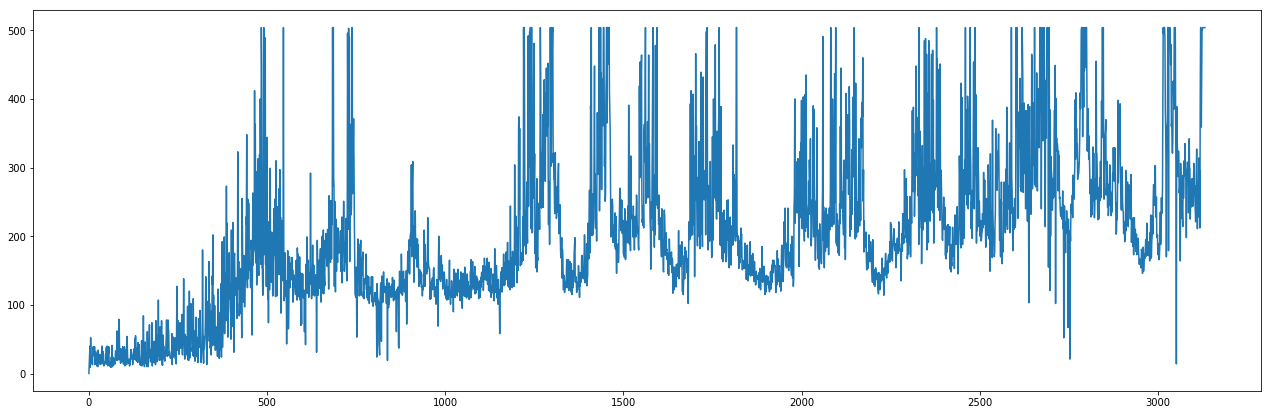

In [3]:
N_IN = env.observation_space.shape[0]
N_OUT = env.action_space.n

class Models(t.nn.Module):
    def __init__(self, hidden = 8):
        super().__init__()
        # state -> expected value
        self.critic = t.nn.Sequential(
            t.nn.Linear(N_IN, hidden),
            t.nn.ReLU(),
            t.nn.Linear(hidden, 1)
        )
        # state -> action weights
        self.actor = t.nn.Sequential(
            t.nn.Linear(N_IN, hidden),
            t.nn.ReLU(),
            t.nn.Linear(hidden, N_OUT),
            t.nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        value = self.critic(x)
        probs = self.actor(x)
        dist = t.distributions.Categorical(probs)
        return dist, value

models = Models(8 * 4).cuda()
opt = t.optim.Adam(models.parameters())
rsums = [0]

while len(rsums) < 10 or np.mean(rsums[-10:]) < 495:
    state = env.reset()
    rsum = 0
    #plot.imshow(env.render(mode='rgb_array'));

    done = False
    while not done:
        log_probs = []
        values = []
        rewards = []
        masks = []
        entropy = 0

        for _ in range(8):
            state = t.FloatTensor(state).unsqueeze(0).cuda()
            dist, value = models(state)
            action = dist.sample()
            state, reward, done, info = env.step(action.cpu().numpy()[0])
            rsum += reward

            entropy += dist.entropy().mean()
            log_probs.append(dist.log_prob(action))
            values.append(value)
            rewards.append(t.FloatTensor([reward]).cuda())
            masks.append(t.FloatTensor([1 - done]).cuda())

        next_state = t.FloatTensor(state).unsqueeze(0).cuda()
        _, next_value = models(next_state)
        returns, R = [], next_value
        for idx in reversed(range(len(rewards))):
            R = rewards[idx] + 0.95 * R * masks[idx]
            returns.append(R)
        returns = list(reversed(returns))

        log_probs = t.cat(log_probs)
        returns = t.cat(returns)
        values = t.cat(values)

        advantage = returns - values

        actor_loss = -(log_probs * advantage.detach()).mean()
        critic_loss = advantage.pow(2).mean()

        loss = actor_loss + 0.5 * critic_loss - 0.001 * entropy

        opt.zero_grad()
        loss.backward()
        opt.step()
    rsums.append(rsum)
plot.figure(figsize=(22,6))
plot.plot(rsums);

In [ ]:
plot.savefig()